**Байесовский классификатор: метод парзеновского окна**

Евгений Борисов <esborisov@sevsu.ru>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

##  загружаем данные 

In [2]:
# from sklearn.datasets import  make_circles

# X,y = make_circles(n_samples=512, noise=.05 ,factor=.3)
# display( X.shape )

# fig, ax = plt.subplots(figsize=(6,5))
# ax.scatter( x=X[:,0], y=X[:,1], marker='.', alpha=.9, c=y )
# ax.grid()

In [3]:
# from sklearn.datasets import make_moons

# X,y = make_moons(n_samples=512, noise=.1)
# display(X.shape)

# fig, ax = plt.subplots(figsize=(6,5))
# ax.scatter( x=X[:,0], y=X[:,1], marker='.', alpha=.9, c=y )
# ax.grid()

(512, 2)

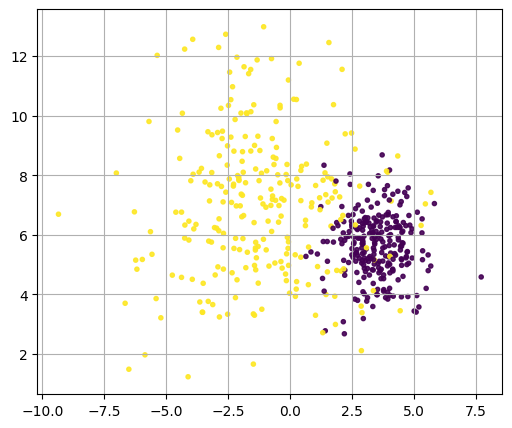

In [4]:
from sklearn.datasets import make_blobs

X,y = make_blobs( n_samples=512, centers=2, cluster_std=[1.0, 2.5,] )
display( X.shape )

fig, ax = plt.subplots(figsize=(6,5))
ax.scatter( x=X[:,0], y=X[:,1], marker='.', alpha=.9, c=y )
ax.grid()

### делим датасет

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.5, )

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((256, 2), (256,), (256, 2), (256,))

In [6]:
del X, y

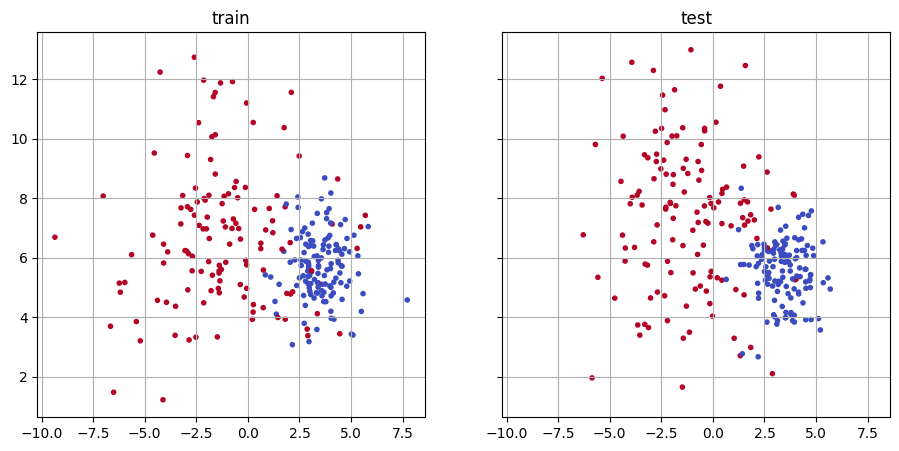

In [7]:
fig,ax = plt.subplots(ncols=2, sharey=True, sharex=True, figsize=(11,5),)

ax[0].scatter(
    x='x', y='y', c='label',marker='.', cmap='coolwarm',
    data=pd.DataFrame(np.hstack([X_train,y_train.reshape(-1,1)]),columns=['x','y','label'])
)
ax[0].set_title('train')
ax[0].grid()

ax[1].scatter(
    x='x', y='y', c='label',marker='.', cmap='coolwarm', 
    data=pd.DataFrame(np.hstack([X_test,y_test.reshape(-1,1)]),columns=['x','y','label'])
)
ax[1].set_title('test')
ax[1].grid()

##  модель плотности

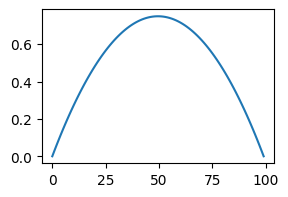

In [8]:
# ядро Епанечникова
def kernel(x): 
    return (1.0 - x**2) * 0.75

fig,ax = plt.subplots(figsize=(3,2),)
ax.plot(kernel(np.linspace(-1,1,100)))

In [9]:
from sklearn.metrics.pairwise import euclidean_distances as metric

__непараметрическая оценка плотности распределения X методом парзеновского окна__

$$
p(u|X,h) = 
\frac{1}{V(h)} \underset{x\in X}{\sum} K\left(\frac{\rho(u,x)}{h}\right)
$$

$K$ - функция ядра ;   
$h$ - параметр ширина окна ;  
$V(h)$ - нормирующий параметр ;   

In [11]:
class ParzenWindowsDensityEstimation:
    
    def __init__( self, win_size=7., metric=metric,  kernel=kernel ):
        assert win_size>0
        self._metric = metric
        self._win_size = win_size
        self._kernel = kernel
        self._x = np.array([])
        self._v = self.V(win_size)
        
    def fit(self,X):
        assert len(X)>0
        self._x = X
        return self
    
    def score(self,u):
        assert len(self._x)>0
        assert len(u)>0
        assert u.shape[1]==self._x.shape[1]
        return self._kernel(self._metric(u,self._x)/self._win_size).sum(axis=1)/self._v 
        
    @staticmethod    
    def V(h): 
        return 4.*h*np.log(h) + 100./(np.log(h)**2)    

##  модель классификатора

__Байесовский классификатор__

$$
a(u|X,Y,\lambda) = \underset{y\in Y}{\operatorname{argmax}} 
\left[ \lambda_y \cdot P_y  \cdot p_y(u|X,h)
\right] 
$$

$\lambda_y$ - штраф за ошибочную классификацию объекта класса y;   
$P_y$ - априорная вероятность класса y (доля объектов класса y) ;   
$p_y$ - оценка плотности распределения объектов класса y ;   

In [12]:
class NaiveBayesClassifier:
    
    def __init__(self,density_estimator, estimator_param=dict()):
        self._density = density_estimator
        self._density_param = estimator_param 
        self._estimators = []
        self._lambda = np.array([])
        self._apriori_prob = np.array([])
        
    def fit(self,X,target,lmbd=[]):
        assert len(X)>0
        assert len(X)==len(target)
        classes = sorted(set(target))
        self._lambda = lmbd if len(lmbd)>0 else [ 1. ]*len(classes)
        assert len(classes)==len(self._lambda)
        self._estimators = [ self._density(**self._density_param).fit(X[target==c,:],) for c in classes ]
        self._apriori_prob = [ (target==c).sum()/len(target) for c in classes ] 
        return self
    
    def score(self,u):
        assert len(u)>0
        assert len(self._lambda)>0
        assert len(self._estimators)>0
        assert len(self._apriori_prob)>0
        assert len(self._estimators)==len(self._apriori_prob)
        assert len(self._estimators)==len(self._lambda)
        return np.vstack([ est.score(u) for est in self._estimators ]).T * self._lambda * self._apriori_prob

    def predict(self,u):
        return np.argmax( self.score(u),axis=1 )
    

## тестируем

In [13]:
model = NaiveBayesClassifier( 
    density_estimator=ParzenWindowsDensityEstimation, 
    estimator_param={'win_size':5.1}
).fit(X_train,y_train,)

In [14]:
from sklearn.metrics import classification_report

predicted = model.predict(X_test)
print( classification_report(y_test,predicted) )

              precision    recall  f1-score   support

           0       0.81      1.00      0.89       128
           1       1.00      0.76      0.86       128

    accuracy                           0.88       256
   macro avg       0.90      0.88      0.88       256
weighted avg       0.90      0.88      0.88       256



## визуализация результатов класификатора

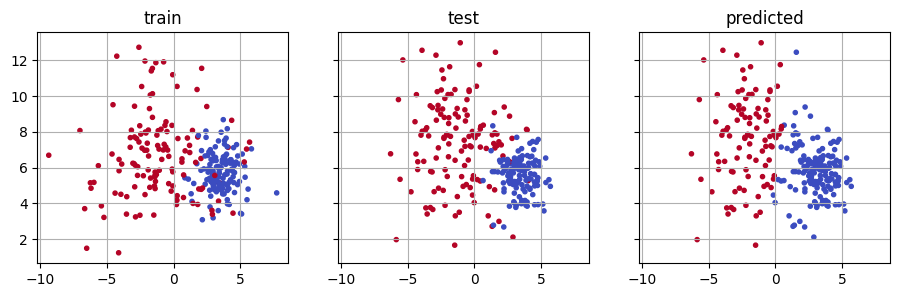

In [15]:
fig,ax = plt.subplots(ncols=3, sharey=True, sharex=True, figsize=(11,3),)

ax[0].scatter(
    x='x', y='y', c='label',marker='.', cmap='coolwarm',
    data=pd.DataFrame(np.hstack([X_train,y_train.reshape(-1,1)]),columns=['x','y','label'])
)
ax[0].set_title('train')
ax[0].grid()

ax[1].scatter(
    x='x', y='y', c='label',marker='.', cmap='coolwarm', 
    data=pd.DataFrame(np.hstack([X_test,y_test.reshape(-1,1)]),columns=['x','y','label'])
)
ax[1].set_title('test')
ax[1].grid()

ax[2].scatter(
    x='x', y='y', c='label',marker='.', cmap='coolwarm', 
    data=pd.DataFrame(np.hstack([X_test,predicted.reshape(-1,1)]),columns=['x','y','label'])
)
ax[2].set_title('predicted')
ax[2].grid()

In [16]:
# строим сетку 

n = 50 # количество разбиений сетки

xx,yy = np.meshgrid(
    np.linspace( X_test[:,0].min()-0.1, X_test[:,0].max()+0.1, n), 
    np.linspace( X_test[:,1].min()-0.1, X_test[:,1].max()+0.1, n)
) # узлы сетки
display( ( xx.shape, yy.shape ) )

xy = np.vstack([xx.ravel(),yy.ravel() ]).T # разворачиваем сетку 
display( xy.shape )

# plt.figure(figsize=(7,7))
# plt.scatter( x=xy[:,0], y=xy[:,1], s=1 )
# plt.show()

((50, 50), (50, 50))

(2500, 2)

In [17]:
from sklearn.preprocessing import MinMaxScaler

score_xy = MinMaxScaler(feature_range=(0.,1.)).fit_transform( model.score(xy) )
# predicted_xy = model.predict(xy).reshape(n,n) # вычисляем скор для каждого узла сетки

Text(0.5, 1.0, 'class 1')

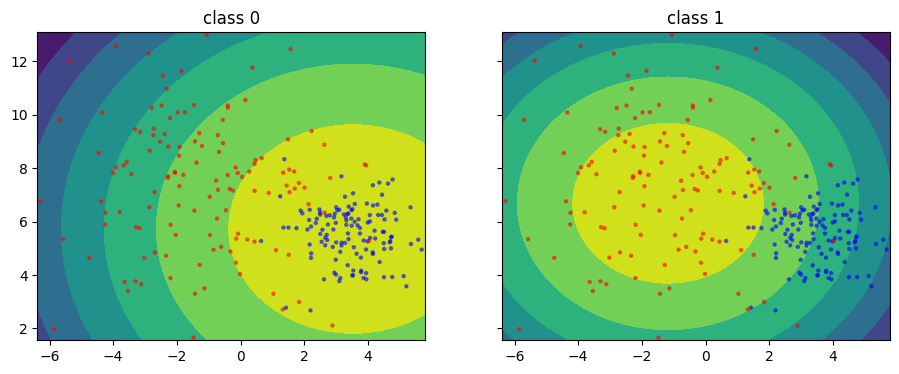

In [18]:
from matplotlib.colors import ListedColormap
fig,ax = plt.subplots(ncols=2,figsize=(11,4),sharey=True)

ax[0].contourf(xx, yy, score_xy[:,0].reshape(n,n) )
ax[0].scatter( x=X_test[:,0], y=X_test[:,1], c=y_test, alpha=.5, s=5, cmap=ListedColormap(['#00f','#f00',]) )
#ax[0].grid()
ax[0].set_title('class 0')

ax[1].contourf(xx, yy, score_xy[:,1].reshape(n,n))
ax[1].scatter( x=X_test[:,0], y=X_test[:,1], c=y_test, alpha=.5, s=5, cmap=ListedColormap(['#00f','#f00',]) )
#ax[1].grid()
ax[1].set_title('class 1')

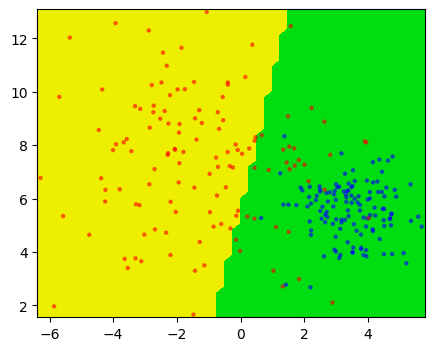

In [19]:
predicted_xy = model.predict(xy).reshape(n,n) # вычисляем скор для каждого узла сетки

fig,ax = plt.subplots(figsize=(5,4))
ax.contourf(xx, yy, predicted_xy, cmap=ListedColormap(['#0d1','#ee0']) )
ax.scatter( x=X_test[:,0], y=X_test[:,1], c=y_test, alpha=.5, s=5, cmap=ListedColormap(['#00f','#f00',]) )
# ax.grid()